# Package Processing

In [183]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import matplotlib.image as image
import pandas as pd

from PIL import Image, ImageFilter
from keras.layers import BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D,Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Processing

讀取 CSV 文件中的資料並顯示圖像類別的數量。以下是對每行程式碼的逐步解釋

In [184]:
csv_path = "/kaggle/input/nptu-dl-final-project/train.csv"
train_path = "/kaggle/input/nptu-dl-final-project/train"

# csv_path = "./nptu-dl-final-project/train.csv"
# train_path = "./nptu-dl-final-project/train"


df = pd.read_csv(csv_path)

y_train = df[['label']]
print(f"All of the img class {len(np.unique(y_train))}")
df

All of the img class 109


,img_file,label
0,78fbc980fba54a0e98da22352d44e51d.jpg,croquet
1,6c761e579cc542ebbaa9a932c9b22b08.jpg,fencing
2,f475146a31564c929e09f0724af3723b.jpg,sailboat racing
3,bfa1d3e9b6684d43ab81eb836670d942.jpg,gymnastics
4,c42ce1c6a0944b0c86a48950f87bc2fe.jpg,roller derby
...,...,...
15193,54e94178e6384782912b465b48979684.jpg,swimming
15194,bb498eaf088349bb8dd9c3d9431ab702.jpg,cheerleading
15195,4640dabdd97a47b1b26ef6bca583927d.jpg,badminton
15196,2593320dd98d400fbc9e0bab4ca98fc1.jpg,luge


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15198 entries, 0 to 15197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_file  15198 non-null  object
 1   label     15198 non-null  object
dtypes: object(2)
memory usage: 237.6+ KB


生成一個橫向條形圖，以顯示每個圖像類別在訓練數據中的圖像數量。

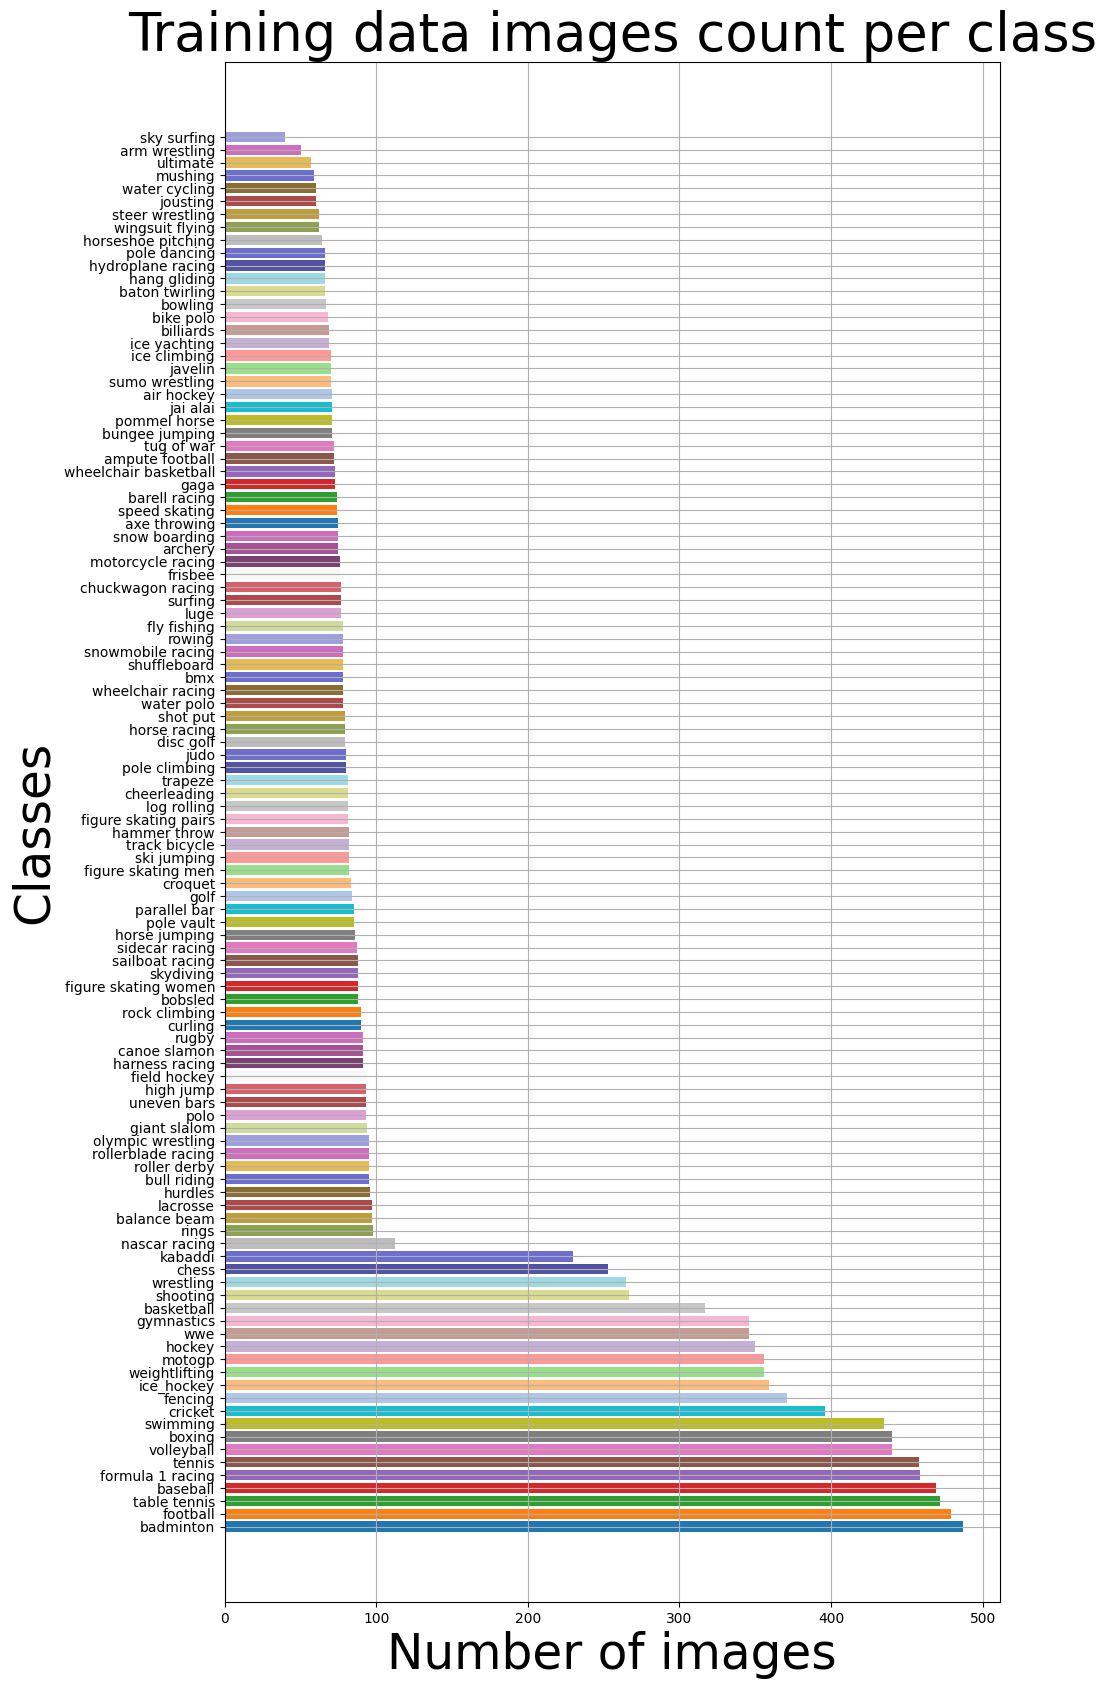

In [186]:
train  = df["label"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(10, 20))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

# Image Processing ( including global parameter )

設定深度學習模型訓練過程中會用到的超參數

In [187]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

BSIZE = 256
L2 = 0.0001

EPOCHS = 10
LR = 0.001

In [188]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                                   # 針對每一像素都做正規化
    rotation_range=40,                                # 隨機將圖片轉動角度
    width_shift_range=0.2,                            # 水平位移圖片
    height_shift_range=0.2,                           # 垂直位移圖片
    shear_range=0.2,                                  # 隨機剪切變換
    zoom_range=0.2,                                   # 隨機將圖片放大
    horizontal_flip=True,                             # 隨機水平翻轉圖像
    fill_mode='nearest',                              # 填充新創建的像素，使用最近的像素值
    validation_split= 0.2                             # 分割數據集， 20% 用於驗證
#     channel_shift_range=50,                         # 隨機修正圖片的顏色 
#     vertical_flip=0.5,                              # 隨機垂直翻轉圖像。垂直翻轉的概率是 0.5，即有 50% 的機會將圖像上下顛倒。
#     brightness_range=[0.2,1.0],                     # 隨機調整圖像的亮度。亮度調整的範圍從 0.2 到 1.0
    )


train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='img_file',
    y_col='label',
    target_size= (IMG_HEIGHT, IMG_WIDTH),
    batch_size=BSIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

# 使索引值對應到類別名稱
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()} 

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='img_file',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BSIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 12159 validated image filenames belonging to 109 classes.
Found 3039 validated image filenames belonging to 109 classes.


將圖像從一個目錄中讀取，調整它們的大小，並將調整大小後的圖像保存到另一個目錄中。

In [189]:
# def resize_images(input_dir, output_dir, target_size):
#     # 確保輸出資料夾存在
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # 遍歷輸入資料夾中的所有文件
#     for filename in os.listdir(input_dir):
#         if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#             file_path = os.path.join(input_dir, filename)
#             output_path = os.path.join(output_dir, filename)
#             with Image.open(file_path) as img:
#                 # 縮放圖像
#                 img = img.resize(target_size, Image.ANTIALIAS)
#                 # 保存縮放後的圖像到輸出資料夾
#                 img.save(output_path)
# output_directory = '/kaggle/working/train_resized'
# target_size = (img_height, img_width)
# resize_images(train_path, output_directory, target_size)

嘗試輸出照片，看是否有對應到自己的路徑中照片

In [190]:
# image1_path = "./nptu-dl-final-project/train/00073f6b7b18474f9c3dad988137d743.jpg"
# image1 = image.imread(image1_path)
# plt.imshow(image1)
# plt.axis(False)
# plt.show()

# image1.shape

# Model Construct 

### Sequential

In [191]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                  ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 128,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters = 256,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# # model.add(Dropout(0.25 , name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(Dropout(0.5, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

### EfficientNet

In [ ]:
# base =  tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)

# for layer in base.layers:
#     layer.trainable =  False

# model = Sequential()
# model.add(base)
# model.add(GlobalAveragePooling2D())

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(len(train_generator.class_indices), activation='softmax'))
# model.summary()

In [192]:
# base =  tf.keras.applications.EfficientNetB1(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)

# for layer in base.layers:
#     layer.trainable =  False

# model = Sequential()
# model.add(base)
# model.add(GlobalAveragePooling2D())

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(len(train_generator.class_indices), activation='softmax'))
# model.summary()

### MobileNetV2 

In [193]:
base = tf.keras.applications.mobilenet_v2.MobileNetV2(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
    
for layer in base.layers:
    layer.trainable =  False

model = Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(len(train_generator.class_indices), activation='softmax'))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### MobileNetV3

In [194]:
# base = tf.keras.applications.MobileNetV3Small(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
# for layer in base.layers:
#     layer.trainable =  False

# model = Sequential()
# model.add(base)
# model.add(GlobalAveragePooling2D())

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(len(train_generator.class_indices), activation='softmax'))
# model.summary()

In [ ]:
# base = tf.keras.applications.MobileNetV3Large(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
# for layer in base.layers:
#     layer.trainable =  False

# model = Sequential()
# model.add(base)
# model.add(GlobalAveragePooling2D())

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(len(train_generator.class_indices), activation='softmax'))
# model.summary()

### VGG16

In [197]:
# base = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
# for layer in base.layers:
#     layer.trainable =  False

# model = Sequential()
# model.add(base)
# model.add(GlobalAveragePooling2D())

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(len(train_generator.class_indices), activation='softmax'))
# model.summary()

# Callback

於深度學習模型訓練過程中進行監控和調整

In [198]:
# def get_lr_callback(batch_size=8):
#     lr_start   = 0.000005
#     lr_max     = 0.00000125 * batch_size  #最高提到哪裡
#     lr_min     = 0.000001
#     lr_ramp_ep = 5    #warmup 次數
#     lr_sus_ep  = 0
#     lr_decay   = 0.8

#     # call back 要用的
#     def lrfn(epoch):
#         if epoch < lr_ramp_ep:  #算(lr_max-lr_min)/5
#             lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
#         elif epoch < lr_ramp_ep + lr_sus_ep:
#             lr = lr_max
#         else:  #learing rate decay
#             lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
#         return lr

#     lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)  #verbose=1
#     return lr_callback
# lrs = get_lr_callback()

In [199]:
my_callbacks=[EarlyStopping(monitor = "val_loss",        # 監測的指標
                            patience = 2,                # 訓練過程中如果驗證集損失值在兩個連續的 epoch 中沒有改善（降低），則停止訓練
                            restore_best_weights=True,   # 在訓練停止後，恢復訓練期間損失值最低時的模型權重
                           ),
              ReduceLROnPlateau(monitor='val_loss',      # 監測的指標
                                factor=0.2,              # 當指標沒有提升時，減少學習率的因子。新學習率 = 學習率 * factor
                                patience=2,              # 訓練過程中如果驗證集損失值在兩個連續的 epoch 中沒有改善（降低），則停止訓練。
                                mode='min'               # 監測指標的目標是達到最小值，即當 val_loss 不再減小時觸發學習率減少
                         )]

# Training

- opt：創建了一個 Adam 優化器，並將學習率設置為 LR

- model.compile：使用 categorical_crossentropy 函數，這在多類分類問題中很常見。同時在訓練和評估過程中使用 accuracy 作為評估指標。

- history：
    1. train_generator：訓練數據生成器，提供訓練數據和標籤

    3. validation_data=validation_generator：驗證數據生成器，提供驗證數據和標籤

    5. epochs=EPOCHS：訓練的迭代次數

    7. callbacks=my_callbacks：使用之前設置的回調函數，以監控訓練過程並進行相應調整。

    9. verbose=1：設置詳細輸出模式，顯示訓練過程的進度條和損失/準確度等信息。

In [200]:
opt = Adam(learning_rate = LR)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS, 
#                   steps_per_epoch=train_generator.samples // train_generator.batch_size,
#                   validation_steps=validation_generator.samples // validation_generator.batch_size,
                    callbacks=my_callbacks,
                    verbose = 1)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step - accuracy: 0.1380 - loss: 4.3385 - val_accuracy: 0.3626 - val_loss: 2.8976 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.4776 - loss: 2.1916 - val_accuracy: 0.5186 - val_loss: 2.0698 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.5771 - loss: 1.7151 - val_accuracy: 0.5670 - val_loss: 1.7396 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.6292 - loss: 1.4643 - val_accuracy: 0.6232 - val_loss: 1.4983 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.6614 - loss: 1.3134 - val_accuracy: 0.6338 - val_loss: 1.4319 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.6839 - loss: 1.2099 - val_accuracy: 0.6180 - val_loss: 1.4520 - learning_rate: 0.0010
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.7048 - loss: 1.1291 - val_accuracy: 0.64

# Evaluate

評估模型在驗證集上的性能
- model.evaluate(): 使用 validation_generator 來評估模型的性能。生成器提供一批批的驗證數據和標籤，模型將在這些數據上計算損失值和其他指標（如準確度）。

In [201]:
scores  = model.evaluate(validation_generator)
print(f"Root mean squared error: {scores[0]:.4f}")
print(f"Test accuracy: {scores[1]:.2%}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6633 - loss: 1.3100


[1.3036881685256958, 0.6627179980278015]

# Visualization

可視化模型訓練過程中的損失值和準確度

In [203]:
def visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies):
    """
    Function to plot the losses and accuracies
    """
    
    fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

    axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
    axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
    axes[0].legend(["train", "validation"])
    axes[0].set_title("Loss")
    axes[0].grid()

    axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
    axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
    axes[1].legend(["train", "validation"])
    axes[1].set_title("Accuracy")
    axes[1].grid()

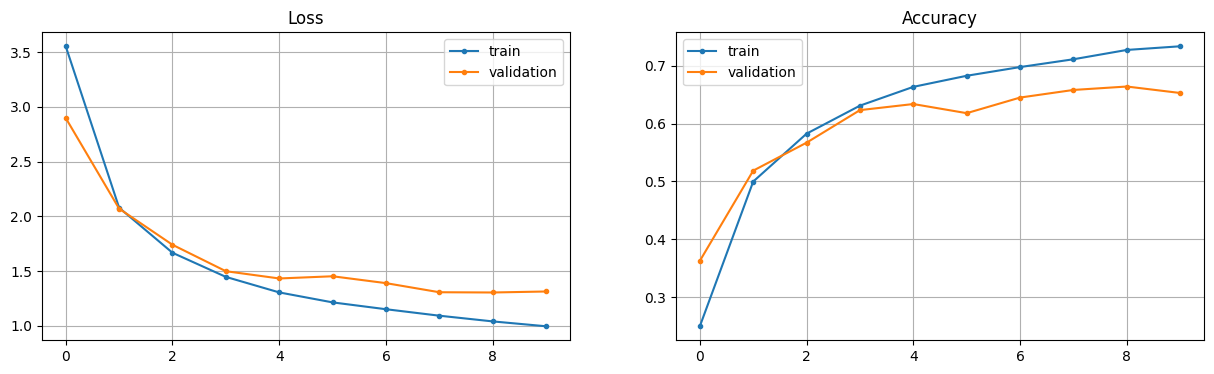

In [204]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
visualize_results(train_loss, train_acc, val_loss, val_acc)

嘗試輸出測試集的照片，以確保有對應到路徑資料夾中

In [205]:
# image2_path = "/kaggle/input/nptu-dl-final-project/test/0017b4ce9b9f48309a6986aea4a1aaa7.jpg"
# image2 = image.imread(image2_path)
# plt.imshow(image2)
# plt.axis(False)
# plt.show()

# image2.shape

# Result

從測試集中生成預測

In [206]:
test_path = "/kaggle/input/nptu-dl-final-project/test"

# 進行像素值的重新縮放
test_datagen = ImageDataGenerator(rescale=1./255) 

# 獲取所有圖像文件名稱
test_filenames = [f for f in os.listdir(test_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# 創建 DataFrame
df_test = pd.DataFrame({
    'img_file': test_filenames,
    'label': ['unknown'] * len(test_filenames)      # 這裡的label隨意填寫，因為我們不會用到
})

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col='img_file',
    y_col=None,                                     # 沒有標籤
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BSIZE,
    class_mode=None,                                # 沒有標籤
    shuffle=False                                   # 保持文件順序
)

predictions = model.predict(test_generator)         # 使用模型對測試集進行預測
predicted_classes = np.argmax(predictions, axis=1)  # 將模型的預測轉換為類別標籤

filenames = test_generator.filenames                # 獲取文件名
filenames = [f.split('/')[-1] for f in filenames]   # 只保留文件名

Found 12436 validated image filenames.
49/49 ━━━━━━━━━━━━━━━━━━━━ 50s 948ms/step


將模型的預測結果保存到 CSV 文件中

In [208]:
predicted_labels = [class_indices[int(k)] for k in predicted_classes]  # 將模型預測的類別索引轉換為相應的類別標籤
results = pd.DataFrame({                                               # 創建一個 DataFrame，包含測試文件的文件名和模型的預測類別
    'img_file': test_filenames,
    'label': predicted_labels
})

results.to_csv('/kaggle/working/results_3.csv', index=False)           # 保存到 .csv 文件
# results.to_csv('/content/results.csv', index=False)